In [10]:
import numpy as np
import resampy
import tensorflow.compat.v1 as tf
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_slim

# Paths to downloaded VGGish files.
checkpoint_path = 'fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt'
pca_params_path = 'vggish_pca_params.npz'

In [11]:
import pandas as pd
df = pd.read_csv('test_df_EDM.csv')
display(df)

,genres,spotify_id,name,artist_id,artist,danceability,energy,speechiness,valence,file_path,main_genre,main_genre_encoded,base_11_genres_EDM_with_vggish_model
0,acid_techno,4J5YDSS5tzUzrYKM9mONgv,Multiverse,"2jvTYwyzxK1FVYGEoKfZLQ, 0bIOCVFnNDbixFxTdPjE7R","Cosmic Boys, Demon Noise",0.630,0.995,0.0420,0.3350,../mp3songs/ACID!_Best_Acid_Techno_Mix/Multive...,techno,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-1.1412535905838013, 0.08442866802215576, 0.1..."
1,hardstyle,4mALGoOhRMFVfphsMppSb2,Muzika - Sefa Remix,"4RbUYWWjEBb4umwqakOEd3, 0caJEGgVuXuSHhhrMCmlkI","Dr. Peacock, Sefa",0.447,0.993,0.0431,0.0389,../mp3songs/Hardcore_Techno_Hardstyle/Muzika -...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-1.065509557723999, -0.4460943639278412, 1.51..."
2,hardstyle,1qt9COCAqTZbWhESNHOqer,Oh My - DJ Paul Elstak's Hardcore Mix,"2dQgOfBP52UwjegY8FwJAY, 123hDJRbi4KtCdBaaKNHW6","The Partysquad, Paul Elstak",0.618,0.772,0.0556,0.1980,../mp3songs/Hardcore_Techno_Hardstyle/Oh My - ...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.9446086883544922, -0.03999096155166626, 0...."
3,90s_house,5mOn7oJdEBmG43elhWGfXo,Let's Get Brutal - Brutal House,6KcNmchIyvo5TqzjfJtwYR,Nitro Deluxe,0.805,0.507,0.1090,0.5370,../mp3songs/90s_House_Classics/Let's Get Bruta...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.4920635521411896, -0.021116137504577637, 0..."
4,90s_house,2F5W5f8COoQKpoGqPcZ1EN,Nitelife - Armand Van Helden Retail Mix,1Tvhj4mF2pvvAT1InLbRKs,Kim English,0.793,0.556,0.0502,0.4120,../mp3songs/90s_House_Classics/Nitelife - Arma...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.8604552745819092, 0.0033154338598251343, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,tekkno,1GQ7bQs2li51f8h7ltunpH,MFB,"5yYwA7jmFlU01EKoLfeNpV, 2dntPqbt5DYNfJHx7Dm8wV","KomaCasper, HRDSFCK",0.809,0.711,0.3020,0.4300,../mp3songs/tekkno/MFB.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[-1.155425786972046, -0.057559579610824585, 0...."
106,jump_up_dnb,5mT3qi3qyzAwSC1Drgp8lb,I Want Your Love V.I.P.,2yJbiseBZFvrCK5GueLnk7,Tsuki,0.533,0.943,0.0584,0.1460,../mp3songs/Jump-Up_Drum_and_Bass/I Want Your ...,dnb,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[-0.4580102860927582, -0.0642130970954895, 0.5..."
107,groove_techno,5si5OPtVvV69chXMtaZkvk,Am I Drunk?,0iS9Zzud5hNvjx0wVfIVvd,Alfa Cornae,0.698,0.870,0.1490,0.4270,../mp3songs/Groove_Techno/Am I Drunk?.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[-0.9225215911865234, 0.028807833790779114, 0...."
108,liquid_dnb,0cMx1KW8B0r9UOKLxCj5aR,No Sunset For Soul,"2w5c2l70mYNDdSLifFyZjJ, 022EiWsch2zvty0qBUksDO","Monty, Liam Bailey",0.702,0.850,0.2660,0.1320,../mp3songs/Liquid_Drum_and_Bass/No Sunset For...,dnb,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.7950646877288818, -0.10124924778938293, 0...."


In [29]:
# import ast  # To safely convert string representation of lists back to lists
#
# # 🔹 Genre Mapping Structure
# GENRE_PRIORITY = {
#     "metal": ["alternative metal", "nu metal", "metal"],
#     "rock": ["rock", "modern rock", "permanent wave", "alternative rock", "post-grunge", "hard rock", "classic rock", "punk", "grunge", "soft rock", "new wave"],
#     "ambient": ["sleep", "environmental"],
#     "pop": ["pop", "dance pop", "latin pop", "singer-songwriter", "mexican pop", "k-pop"],
#     "latino": ["musica mexicana", "reggaeton", "latin hip hop", "tropical", "salsa", "bachata"],
#     "classical": ["classical"],
#     "country": ["country", "contemporary country"],
#     "rnb": ["r&b", "contemporary r&b", "soul", "neo soul"],
#     "rap": ["rap", "hip hop", "trap", "pop rap", "gangster rap"],
#     "edm": ["edm", "electro house"],
#     "eurodance": ["eurodance"]
# }
#
# # 🔹 Create Reverse Mapping (Genre → Main Genre)
# # 🔹 Create Reverse Mapping (Genre → Main Genre)
# GENRE_LOOKUP = {genre: main_genre for main_genre, subgenres in GENRE_PRIORITY.items() for genre in subgenres}
#
# # 🔹 Function to Assign One Main Genre
# def get_main_genre(genre_str):
#     try:
#         genre_list = ast.literal_eval(genre_str)  # Convert string to actual list
#         if not isinstance(genre_list, list) or not genre_list:
#             return None  # Handle invalid cases
#
#         for genre in genre_list:
#             if genre in GENRE_LOOKUP:
#                 return GENRE_LOOKUP[genre]  # Return first matching main genre
#
#         return genre_list[0]  # If no match, return the first genre in the list
#     except (ValueError, SyntaxError):
#         return None  # Handle malformed inputs
#
# # 🔹 Apply Function to DataFrame
# df['main_genre'] = df['genres'].apply(get_main_genre)
# df

,name,artist,spotify_id,preview,img,danceability,energy,loudness,speechiness,acousticness,...,speechiness_artist,valence_artist,artist_id,genres,file_path,genres_str,genre_array2,VGG_embeddings_8_seconds_base_43_multilabel_test,main_genre,VGG_embeddings_8_seconds_finetuned_43_multilabel_test
0,Revolver,Rage Against The Machine,655gNlXQ7zb9jPrTuqJ4mf,https://p.scdn.co/mp3-preview/d0ed6e220218ce8e...,https://i.scdn.co/image/ab67616d0000b273053f00...,0.350,0.792,-8.214,0.0951,0.008760,...,0.146351,0.486658,2d0hyoQ5ynDBnkvAbJKORj,"['alternative metal', 'alternative rock', 'har...",../mp3songs/43_genres_multi_label/Revolver.mp3,"['alternative metal', 'alternative rock', 'har...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.8018218278884888, -0.22799083590507507, 0....",metal,"[-12.901688575744629, -4.653236389160156, 1.36..."
1,Last First Kiss,One Direction,0KqlLyIGuBZWqzNwP9rypc,https://p.scdn.co/mp3-preview/6aaeaaab31f77494...,https://i.scdn.co/image/ab67616d0000b2734e31e0...,0.538,0.819,-2.662,0.0435,0.044500,...,0.048473,0.547464,4AK6F7OLvEQ5QYCBNiQWHq,['pop'],../mp3songs/43_genres_multi_label/Last First K...,['pop'],[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0...,"[-0.7555744647979736, -0.009560048580169678, 0...",pop,"[-10.984193801879883, -3.339414358139038, 0.89..."
2,D U Down,Kevin Gates,0fivzT98mFK9EZAtJtV2iW,https://p.scdn.co/mp3-preview/471515955e2e5a3c...,https://i.scdn.co/image/ab67616d0000b2739d34eb...,0.795,0.597,-6.592,0.2630,0.014200,...,0.249900,0.507829,1gPhS1zisyXr5dHTYZyiMe,"['pop rap', 'rap', 'trap']",../mp3songs/43_genres_multi_label/D U Down.mp3,"['pop rap', 'rap', 'trap']",[0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0...,"[-0.9172438383102417, -0.06023094058036804, 0....",rap,"[-10.520010948181152, -2.7087795734405518, -2...."
3,How I Move (feat. Lil Baby),Flipp Dinero,0jBJIQuToUUOEx7JJkiPzm,https://p.scdn.co/mp3-preview/777e33a158d29f89...,https://i.scdn.co/image/ab67616d0000b2731dbffc...,0.826,0.635,-5.181,0.2120,0.102000,...,0.127400,0.764000,2HUwZ0kumzCSlhFcjFZfpp,['trap'],../mp3songs/43_genres_multi_label/How I Move (...,['trap'],[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.8096623420715332, 0.05372752249240875, 0.8...",rap,"[-11.814701080322266, -3.053117513656616, -1.2..."
4,Workin' on,Colt Ford,5kSPD3rOo2hGYVwheIxpv8,https://p.scdn.co/mp3-preview/0805a9f57265f0ab...,https://i.scdn.co/image/ab67616d0000b273e7d22b...,0.521,0.804,-4.395,0.0569,0.065800,...,0.084006,0.630242,0OpWIlokQeE7BNQMhuu2Nx,"['contemporary country', 'country']",../mp3songs/43_genres_multi_label/Workin' on.mp3,"['contemporary country', 'country']",[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.7705914974212646, 0.24718138575553894, 0.1...",country,"[-10.391701698303223, -4.478461742401123, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,She Ain't You,Chris Brown,3dhvQUA0NyrAea4vQ7X6Gn,https://p.scdn.co/mp3-preview/dc674b441cd870ba...,https://i.scdn.co/image/ab67616d0000b2730a1d20...,0.634,0.716,-6.502,0.1280,0.034100,...,0.130031,0.486374,7bXgB6jMjp9ATFy66eO08Z,"['r&b', 'rap']",../mp3songs/43_genres_multi_label/She Ain't Yo...,"['r&b', 'rap']",[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.5154333114624023, 0.04339984059333801, 0.2...",rnb,"[-12.702393531799316, -4.214264869689941, -0.6..."
920,Sexy Chick (feat. Akon),David Guetta,4MKzCHlZvkwJOQRNkdw4zq,https://p.scdn.co/mp3-preview/7a3b6610900563c5...,https://i.scdn.co/image/ab67616d0000b273804954...,0.809,0.562,-7.694,0.0534,0.081600,...,0.072195,0.504891,1Cs0zKBU1kc0i8ypK3B9ai,"['dance pop', 'edm', 'pop']",../mp3songs/43_genres_multi_label/Sexy Chick (...,"['dance pop', 'edm', 'pop']",[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0...,"[-0.5577372312545776, 0.12402720004320145, 0.2...",pop,"[-10.285187721252441, -3.5387980937957764, 0.0..."
921,Mouth for War,Pantera,6rkeaQRCWZxwkjhyqgxjXi,https://p.scdn.co/mp3-preview/cb8116effd9beb66...,https://i.scdn.co/image/ab67616d0000b273347c0a...,

In [4]:
def convert_genre_array(saved_str):
    cleaned_str = saved_str.replace("[", "").replace("]", "").replace("\n", " ")
    array_list = list(map(int, cleaned_str.split()))
    return np.array(array_list)
df["genre_array2"] = df["genre_array2"].apply(convert_genre_array)
df

,name,artist,spotify_id,preview,img,danceability,energy,loudness,speechiness,acousticness,...,liveness_artist,speechiness_artist,valence_artist,artist_id,genres,file_path,genres_str,genre_array2,VGG_embeddings_8_seconds_base_43_multilabel_test,main_genre
0,Revolver,Rage Against The Machine,655gNlXQ7zb9jPrTuqJ4mf,https://p.scdn.co/mp3-preview/d0ed6e220218ce8e...,https://i.scdn.co/image/ab67616d0000b273053f00...,0.350,0.792,-8.214,0.0951,0.008760,...,0.277857,0.146351,0.486658,2d0hyoQ5ynDBnkvAbJKORj,"['alternative metal', 'alternative rock', 'har...",../mp3songs/43_genres_multi_label/Revolver.mp3,"['alternative metal', 'alternative rock', 'har...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8018218278884888, -0.22799083590507507, 0....",metal
1,Last First Kiss,One Direction,0KqlLyIGuBZWqzNwP9rypc,https://p.scdn.co/mp3-preview/6aaeaaab31f77494...,https://i.scdn.co/image/ab67616d0000b2734e31e0...,0.538,0.819,-2.662,0.0435,0.044500,...,0.178461,0.048473,0.547464,4AK6F7OLvEQ5QYCBNiQWHq,['pop'],../mp3songs/43_genres_multi_label/Last First K...,['pop'],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[-0.7555744647979736, -0.009560048580169678, 0...",pop
2,D U Down,Kevin Gates,0fivzT98mFK9EZAtJtV2iW,https://p.scdn.co/mp3-preview/471515955e2e5a3c...,https://i.scdn.co/image/ab67616d0000b2739d34eb...,0.795,0.597,-6.592,0.2630,0.014200,...,0.184913,0.249900,0.507829,1gPhS1zisyXr5dHTYZyiMe,"['pop rap', 'rap', 'trap']",../mp3songs/43_genres_multi_label/D U Down.mp3,"['pop rap', 'rap', 'trap']","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...","[-0.9172438383102417, -0.06023094058036804, 0....",rap
3,How I Move (feat. Lil Baby),Flipp Dinero,0jBJIQuToUUOEx7JJkiPzm,https://p.scdn.co/mp3-preview/777e33a158d29f89...,https://i.scdn.co/image/ab67616d0000b2731dbffc...,0.826,0.635,-5.181,0.2120,0.102000,...,0.203667,0.127400,0.764000,2HUwZ0kumzCSlhFcjFZfpp,['trap'],../mp3songs/43_genres_multi_label/How I Move (...,['trap'],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.8096623420715332, 0.05372752249240875, 0.8...",rap
4,Workin' on,Colt Ford,5kSPD3rOo2hGYVwheIxpv8,https://p.scdn.co/mp3-preview/0805a9f57265f0ab...,https://i.scdn.co/image/ab67616d0000b273e7d22b...,0.521,0.804,-4.395,0.0569,0.065800,...,0.157861,0.084006,0.630242,0OpWIlokQeE7BNQMhuu2Nx,"['contemporary country', 'country']",../mp3songs/43_genres_multi_label/Workin' on.mp3,"['contemporary country', 'country']","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.7705914974212646, 0.24718138575553894, 0.1...",country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,She Ain't You,Chris Brown,3dhvQUA0NyrAea4vQ7X6Gn,https://p.scdn.co/mp3-preview/dc674b441cd870ba...,https://i.scdn.co/image/ab67616d0000b2730a1d20...,0.634,0.716,-6.502,0.1280,0.034100,...,0.172564,0.130031,0.486374,7bXgB6jMjp9ATFy66eO08Z,"['r&b', 'rap']",../mp3songs/43_genres_multi_label/She Ain't Yo...,"['r&b', 'rap']","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[-0.5154333114624023, 0.04339984059333801, 0.2...",rnb
920,Sexy Chick (feat. Akon),David Guetta,4MKzCHlZvkwJOQRNkdw4zq,https://p.scdn.co/mp3-preview/7a3b6610900563c5...,https://i.scdn.co/image/ab67616d0000b273804954...,0.809,0.562,-7.694,0.0534,0.081600,...,0.215116,0.072195,0.504891,1Cs0zKBU1kc0i8ypK3B9ai,"['dance pop', 'edm', 'pop']",../mp3songs/43_genres_multi_label/Sexy Chick (...,"['dance pop', 'edm', 'pop']","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ...","[-0.5577372312545776, 0.12402720004320145, 0.2...",pop
921,Mouth for War,Pantera,6rkeaQRCWZxwkjhyqgxjXi,https://p.scdn.co/mp3-preview/cb8116effd9beb66...,https://i.scdn.co/image/ab67616d0000b273347c0a...,0.329,0.954,-7.006,0.0722,0.000004,...,0.208891,0.088555,0.365315,14pVkFUHDL207LzLHtSA18,"['alternative metal', 'hard rock', 'metal', 'n...",../mp3songs/43_genres_multi_label/Mouth for Wa...,"['alternative metal', 'hard rock', 'metal', 'n...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.7344160079956055, -0.0542

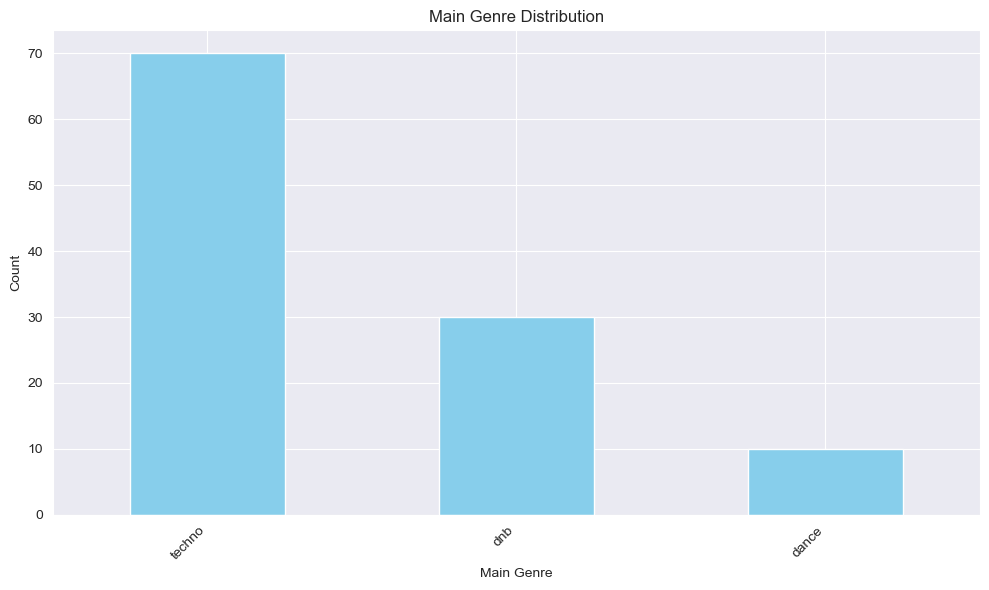

In [12]:
import matplotlib.pyplot as plt

# Count occurrences of each main genre
genre_counts = df['main_genre'].value_counts()

# Plot Histogram
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Main Genre Distribution')
plt.xlabel('Main Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
import numpy as np
import pandas as pd
import librosa
# Load the VGGish model
def select_strongest_8_seconds(y, sr):
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, trim=True)
    # Calculate the cumulative onset strength for each 8-second segment
    hop_length = 512
    frame_length = int(8 * sr / hop_length)
    onset_env_cumsum = np.cumsum(onset_env)
    max_strength = 0
    start_frame = 0

    for i in range(len(onset_env) - frame_length):
        strength = onset_env_cumsum[i + frame_length] - onset_env_cumsum[i]
        if strength > max_strength:
            max_strength = strength
            start_frame = i

    # Align the start of the 8-second segment with the nearest beat
    start_time = librosa.frames_to_time(start_frame, sr=sr, hop_length=hop_length)
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)

    if len(beat_times) > 0:
        nearest_beat_time = min(beat_times, key=lambda x: abs(x - start_time))
        start_time = nearest_beat_time

    end_time = start_time + 8
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_selected_seconds = y[start_sample:end_sample]
    return y_selected_seconds, start_time, end_time

In [14]:
import librosa

def preprocess_audio(file_path):
    # Load the audio file
    x, sr = librosa.load(file_path, sr=None)
    y_selected_seconds, start_time, end_time = select_strongest_8_seconds(x, sr)

    # Resample to 16 kHz
    x_16k = librosa.resample(y=y_selected_seconds, orig_sr=sr, target_sr=16000)

    return x_16k, 16000

In [15]:
def get_vggish_embedding(file_path):
    # Preprocess the audio file
    samples, sr = preprocess_audio(file_path)

    # Produce a batch of log mel spectrogram examples
    input_batch = vggish_input.waveform_to_examples(samples, sr)

    # Define VGGish, load the checkpoint, and run the batch through the model to produce embeddings
    with tf.Graph().as_default(), tf.Session() as sess:
        vggish_slim.define_vggish_slim()
        vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

        features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
        embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

        [embedding_batch] = sess.run([embedding_tensor], feed_dict={features_tensor: input_batch})

        # Postprocess the results to produce whitened quantized embeddings
        # pproc = vggish_postprocess.Postprocessor(pca_params_path)
        # postprocessed_batch = pproc.postprocess(embedding_batch)

        return embedding_batch

# Example usage
embedding = get_vggish_embedding('(One of Those) Crazy Girls.mp3')
print(embedding.flatten())

/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt
[-2.7325857  -0.0921064   4.6344347  ... -0.85889184 -1.0982826
 -0.9285034 ]


In [16]:
len(embedding.flatten().shape)

1

In [17]:
type(embedding.flatten())

numpy.ndarray

In [19]:
# Convert the numpy array to a list of floats
embedding_list = embedding.flatten().tolist()

# Verify the type
print(type(embedding_list))  # This should print <class 'list'>

<class 'list'>


In [24]:
df

,name,artist,spotify_id,preview,img,danceability,energy,loudness,speechiness,acousticness,...,liveness_artist,speechiness_artist,valence_artist,artist_id,genres,file_path,genres_str,genre_array2,VGG_embeddings_8_seconds_base_43_multilabel_test,main_genre
0,Revolver,Rage Against The Machine,655gNlXQ7zb9jPrTuqJ4mf,https://p.scdn.co/mp3-preview/d0ed6e220218ce8e...,https://i.scdn.co/image/ab67616d0000b273053f00...,0.350,0.792,-8.214,0.0951,0.008760,...,0.277857,0.146351,0.486658,2d0hyoQ5ynDBnkvAbJKORj,"['alternative metal', 'alternative rock', 'har...",../mp3songs/43_genres_multi_label/Revolver.mp3,"['alternative metal', 'alternative rock', 'har...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.8018218278884888, -0.22799083590507507, 0....",metal
1,Last First Kiss,One Direction,0KqlLyIGuBZWqzNwP9rypc,https://p.scdn.co/mp3-preview/6aaeaaab31f77494...,https://i.scdn.co/image/ab67616d0000b2734e31e0...,0.538,0.819,-2.662,0.0435,0.044500,...,0.178461,0.048473,0.547464,4AK6F7OLvEQ5QYCBNiQWHq,['pop'],../mp3songs/43_genres_multi_label/Last First K...,['pop'],[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0...,"[-0.7555744647979736, -0.009560048580169678, 0...",pop
2,D U Down,Kevin Gates,0fivzT98mFK9EZAtJtV2iW,https://p.scdn.co/mp3-preview/471515955e2e5a3c...,https://i.scdn.co/image/ab67616d0000b2739d34eb...,0.795,0.597,-6.592,0.2630,0.014200,...,0.184913,0.249900,0.507829,1gPhS1zisyXr5dHTYZyiMe,"['pop rap', 'rap', 'trap']",../mp3songs/43_genres_multi_label/D U Down.mp3,"['pop rap', 'rap', 'trap']",[0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0...,"[-0.9172438383102417, -0.06023094058036804, 0....",rap
3,How I Move (feat. Lil Baby),Flipp Dinero,0jBJIQuToUUOEx7JJkiPzm,https://p.scdn.co/mp3-preview/777e33a158d29f89...,https://i.scdn.co/image/ab67616d0000b2731dbffc...,0.826,0.635,-5.181,0.2120,0.102000,...,0.203667,0.127400,0.764000,2HUwZ0kumzCSlhFcjFZfpp,['trap'],../mp3songs/43_genres_multi_label/How I Move (...,['trap'],[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.8096623420715332, 0.05372752249240875, 0.8...",rap
4,Workin' on,Colt Ford,5kSPD3rOo2hGYVwheIxpv8,https://p.scdn.co/mp3-preview/0805a9f57265f0ab...,https://i.scdn.co/image/ab67616d0000b273e7d22b...,0.521,0.804,-4.395,0.0569,0.065800,...,0.157861,0.084006,0.630242,0OpWIlokQeE7BNQMhuu2Nx,"['contemporary country', 'country']",../mp3songs/43_genres_multi_label/Workin' on.mp3,"['contemporary country', 'country']",[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.7705914974212646, 0.24718138575553894, 0.1...",country
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,She Ain't You,Chris Brown,3dhvQUA0NyrAea4vQ7X6Gn,https://p.scdn.co/mp3-preview/dc674b441cd870ba...,https://i.scdn.co/image/ab67616d0000b2730a1d20...,0.634,0.716,-6.502,0.1280,0.034100,...,0.172564,0.130031,0.486374,7bXgB6jMjp9ATFy66eO08Z,"['r&b', 'rap']",../mp3songs/43_genres_multi_label/She Ain't Yo...,"['r&b', 'rap']",[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.5154333114624023, 0.04339984059333801, 0.2...",rnb
920,Sexy Chick (feat. Akon),David Guetta,4MKzCHlZvkwJOQRNkdw4zq,https://p.scdn.co/mp3-preview/7a3b6610900563c5...,https://i.scdn.co/image/ab67616d0000b273804954...,0.809,0.562,-7.694,0.0534,0.081600,...,0.215116,0.072195,0.504891,1Cs0zKBU1kc0i8ypK3B9ai,"['dance pop', 'edm', 'pop']",../mp3songs/43_genres_multi_label/Sexy Chick (...,"['dance pop', 'edm', 'pop']",[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0...,"[-0.5577372312545776, 0.12402720004320145, 0.2...",pop
921,Mouth for War,Pantera,6rkeaQRCWZxwkjhyqgxjXi,https://p.scdn.co/mp3-preview/cb8116effd9beb66...,https://i.scdn.co/image/ab67616d0000b273347c0a...,0.329,0.954,-7.006,0.0722,0.000004,...,0.208891,0.088555,0.365315,14pVkFUHDL207LzLHtSA18,"['alternative metal', 'hard rock', 'metal', 'n...",../mp3songs/43_genres_multi_label/Mouth for Wa...,"['alternative metal', 'hard rock', 'metal', 'n...",[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.7344160079956055, -0.05429854989051819, -

In [18]:
from qdrant_client import QdrantClient, models
import pandas as pd
import numpy as np
from tqdm import tqdm

# Initialize Qdrant client
client = QdrantClient("http://localhost:6333")
csv_file = 'test_df_EDM.csv'

# Load the DataFrame
# df = pd.read_csv(csv_file)
df

,genres,spotify_id,name,artist_id,artist,danceability,energy,speechiness,valence,file_path,main_genre,main_genre_encoded,base_11_genres_EDM_with_vggish_model
0,acid_techno,4J5YDSS5tzUzrYKM9mONgv,Multiverse,"2jvTYwyzxK1FVYGEoKfZLQ, 0bIOCVFnNDbixFxTdPjE7R","Cosmic Boys, Demon Noise",0.630,0.995,0.0420,0.3350,../mp3songs/ACID!_Best_Acid_Techno_Mix/Multive...,techno,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-1.1412535905838013, 0.08442866802215576, 0.1..."
1,hardstyle,4mALGoOhRMFVfphsMppSb2,Muzika - Sefa Remix,"4RbUYWWjEBb4umwqakOEd3, 0caJEGgVuXuSHhhrMCmlkI","Dr. Peacock, Sefa",0.447,0.993,0.0431,0.0389,../mp3songs/Hardcore_Techno_Hardstyle/Muzika -...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-1.065509557723999, -0.4460943639278412, 1.51..."
2,hardstyle,1qt9COCAqTZbWhESNHOqer,Oh My - DJ Paul Elstak's Hardcore Mix,"2dQgOfBP52UwjegY8FwJAY, 123hDJRbi4KtCdBaaKNHW6","The Partysquad, Paul Elstak",0.618,0.772,0.0556,0.1980,../mp3songs/Hardcore_Techno_Hardstyle/Oh My - ...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.9446086883544922, -0.03999096155166626, 0...."
3,90s_house,5mOn7oJdEBmG43elhWGfXo,Let's Get Brutal - Brutal House,6KcNmchIyvo5TqzjfJtwYR,Nitro Deluxe,0.805,0.507,0.1090,0.5370,../mp3songs/90s_House_Classics/Let's Get Bruta...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.4920635521411896, -0.021116137504577637, 0..."
4,90s_house,2F5W5f8COoQKpoGqPcZ1EN,Nitelife - Armand Van Helden Retail Mix,1Tvhj4mF2pvvAT1InLbRKs,Kim English,0.793,0.556,0.0502,0.4120,../mp3songs/90s_House_Classics/Nitelife - Arma...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.8604552745819092, 0.0033154338598251343, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,tekkno,1GQ7bQs2li51f8h7ltunpH,MFB,"5yYwA7jmFlU01EKoLfeNpV, 2dntPqbt5DYNfJHx7Dm8wV","KomaCasper, HRDSFCK",0.809,0.711,0.3020,0.4300,../mp3songs/tekkno/MFB.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[-1.155425786972046, -0.057559579610824585, 0...."
106,jump_up_dnb,5mT3qi3qyzAwSC1Drgp8lb,I Want Your Love V.I.P.,2yJbiseBZFvrCK5GueLnk7,Tsuki,0.533,0.943,0.0584,0.1460,../mp3songs/Jump-Up_Drum_and_Bass/I Want Your ...,dnb,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[-0.4580102860927582, -0.0642130970954895, 0.5..."
107,groove_techno,5si5OPtVvV69chXMtaZkvk,Am I Drunk?,0iS9Zzud5hNvjx0wVfIVvd,Alfa Cornae,0.698,0.870,0.1490,0.4270,../mp3songs/Groove_Techno/Am I Drunk?.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[-0.9225215911865234, 0.028807833790779114, 0...."
108,liquid_dnb,0cMx1KW8B0r9UOKLxCj5aR,No Sunset For Soul,"2w5c2l70mYNDdSLifFyZjJ, 022EiWsch2zvty0qBUksDO","Monty, Liam Bailey",0.702,0.850,0.2660,0.1320,../mp3songs/Liquid_Drum_and_Bass/No Sunset For...,dnb,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.7950646877288818, -0.10124924778938293, 0...."


In [19]:
df

,genres,spotify_id,name,artist_id,artist,danceability,energy,speechiness,valence,file_path,main_genre,main_genre_encoded,base_11_genres_EDM_with_vggish_model
0,acid_techno,4J5YDSS5tzUzrYKM9mONgv,Multiverse,"2jvTYwyzxK1FVYGEoKfZLQ, 0bIOCVFnNDbixFxTdPjE7R","Cosmic Boys, Demon Noise",0.630,0.995,0.0420,0.3350,../mp3songs/ACID!_Best_Acid_Techno_Mix/Multive...,techno,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-1.1412535905838013, 0.08442866802215576, 0.1..."
1,hardstyle,4mALGoOhRMFVfphsMppSb2,Muzika - Sefa Remix,"4RbUYWWjEBb4umwqakOEd3, 0caJEGgVuXuSHhhrMCmlkI","Dr. Peacock, Sefa",0.447,0.993,0.0431,0.0389,../mp3songs/Hardcore_Techno_Hardstyle/Muzika -...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-1.065509557723999, -0.4460943639278412, 1.51..."
2,hardstyle,1qt9COCAqTZbWhESNHOqer,Oh My - DJ Paul Elstak's Hardcore Mix,"2dQgOfBP52UwjegY8FwJAY, 123hDJRbi4KtCdBaaKNHW6","The Partysquad, Paul Elstak",0.618,0.772,0.0556,0.1980,../mp3songs/Hardcore_Techno_Hardstyle/Oh My - ...,techno,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[-0.9446086883544922, -0.03999096155166626, 0...."
3,90s_house,5mOn7oJdEBmG43elhWGfXo,Let's Get Brutal - Brutal House,6KcNmchIyvo5TqzjfJtwYR,Nitro Deluxe,0.805,0.507,0.1090,0.5370,../mp3songs/90s_House_Classics/Let's Get Bruta...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.4920635521411896, -0.021116137504577637, 0..."
4,90s_house,2F5W5f8COoQKpoGqPcZ1EN,Nitelife - Armand Van Helden Retail Mix,1Tvhj4mF2pvvAT1InLbRKs,Kim English,0.793,0.556,0.0502,0.4120,../mp3songs/90s_House_Classics/Nitelife - Arma...,dance,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[-0.8604552745819092, 0.0033154338598251343, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,tekkno,1GQ7bQs2li51f8h7ltunpH,MFB,"5yYwA7jmFlU01EKoLfeNpV, 2dntPqbt5DYNfJHx7Dm8wV","KomaCasper, HRDSFCK",0.809,0.711,0.3020,0.4300,../mp3songs/tekkno/MFB.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[-1.155425786972046, -0.057559579610824585, 0...."
106,jump_up_dnb,5mT3qi3qyzAwSC1Drgp8lb,I Want Your Love V.I.P.,2yJbiseBZFvrCK5GueLnk7,Tsuki,0.533,0.943,0.0584,0.1460,../mp3songs/Jump-Up_Drum_and_Bass/I Want Your ...,dnb,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[-0.4580102860927582, -0.0642130970954895, 0.5..."
107,groove_techno,5si5OPtVvV69chXMtaZkvk,Am I Drunk?,0iS9Zzud5hNvjx0wVfIVvd,Alfa Cornae,0.698,0.870,0.1490,0.4270,../mp3songs/Groove_Techno/Am I Drunk?.mp3,techno,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[-0.9225215911865234, 0.028807833790779114, 0...."
108,liquid_dnb,0cMx1KW8B0r9UOKLxCj5aR,No Sunset For Soul,"2w5c2l70mYNDdSLifFyZjJ, 022EiWsch2zvty0qBUksDO","Monty, Liam Bailey",0.702,0.850,0.2660,0.1320,../mp3songs/Liquid_Drum_and_Bass/No Sunset For...,dnb,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[-0.7950646877288818, -0.10124924778938293, 0...."


In [20]:

# Initialize the new column to None
df['fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1'] = None

batch_size = 10
embeddings = []

# Global ID counter
global_id = 0

# Iterate over each row in the DataFrame with progress tracking
for i, file_path in enumerate(tqdm(df['file_path'])):
    embedding = get_vggish_embedding(file_path)  # Compute VGGish embedding
    embedding = embedding.flatten()  # Flatten the embedding

    # Ensure embeddings have a fixed dimension of 1024 (pad with zeros if needed)
    if embedding.shape[0] < 1024:
        print(f"Embedding dimension mismatch: {embedding.shape[0]}, padding with zeros.")
        embedding = np.pad(embedding, (0, 1024 - embedding.shape[0]), 'constant')

    embeddings.append(embedding)

    # Assign the embedding to the DataFrame
    df.at[i, 'fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1'] = embedding.tolist()

    # Process batch every `batch_size` rows or on the last row
    if (i + 1) % batch_size == 0 or (i + 1) == len(df):
        points = []  # List to hold batch points

        for index, (embedding, row) in enumerate(zip(embeddings, df.iloc[i + 1 - batch_size:i + 1].iterrows())):
            # Convert payload values to standard Python types (avoid NumPy types)
            payload = {
                k: (v.item() if isinstance(v, np.generic) else v)
                for k, v in row[1].drop(['fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1','base_11_genres_EDM_with_vggish_model']).to_dict().items()
            }

            # Create a PointStruct object for Qdrant
            point = models.PointStruct(
                id=global_id + index,  # Unique ID for each point
                vector=embedding.tolist(),  # Convert NumPy array to list
                payload=payload  # Metadata for retrieval
            )

            points.append(point)

        # Upsert the batch of points into Qdrant
        operation_info = client.upsert(
            collection_name="fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1",
            wait=True,
            points=points,
        )

        print(f"Upserted batch {(i + 1) // batch_size} from: {csv_file}")
        print(operation_info)

        # Update global ID counter
        global_id += len(points)

        # Reset embeddings list for the next batch
        embeddings = []

        # Save the updated DataFrame periodically
        df.to_csv(csv_file, index=False)
        print(f"Saved DataFrame with embeddings to: {csv_file}")

# Final save after loop completes
df.to_csv(csv_file, index=False)
print(f"Final saved DataFrame with embeddings to: {csv_file}")


  0%|          | 0/110 [00:00<?, ?it/s]/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  1%|          | 1/110 [00:01<02:57,  1.62s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  2%|▏         | 2/110 [00:02<02:23,  1.33s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  3%|▎         | 3/110 [00:03<02:09,  1.21s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  4%|▎         | 4/110 [00:04<01:59,  1.13s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  5%|▍         | 5/110 [00:05<01:58,  1.13s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  5%|▌         | 6/110 [00:06<01:51,  1.07s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  6%|▋         | 7/110 [00:07<01:46,  1.03s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  7%|▋         | 8/110 [00:08<01:41,  1.00it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  8%|▊         | 9/110 [00:09<01:37,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


  9%|▉         | 10/110 [00:10<01:39,  1.00it/s]

Upserted batch 1 from: test_df_EDM.csv
operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 10%|█         | 11/110 [00:11<01:36,  1.03it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 11%|█         | 12/110 [00:12<01:32,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 12%|█▏        | 13/110 [00:13<01:30,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 13%|█▎        | 14/110 [00:14<01:30,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 14%|█▎        | 15/110 [00:15<01:28,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 15%|█▍        | 16/110 [00:16<01:26,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 15%|█▌        | 17/110 [00:17<01:25,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 16%|█▋        | 18/110 [00:18<01:23,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 17%|█▋        | 19/110 [00:18<01:22,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 18%|█▊        | 20/110 [00:20<01:26,  1.04it/s]

Upserted batch 2 from: test_df_EDM.csv
operation_id=1 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 19%|█▉        | 21/110 [00:21<01:32,  1.04s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 20%|██        | 22/110 [00:22<01:31,  1.04s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 21%|██        | 23/110 [00:23<01:26,  1.00it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 22%|██▏       | 24/110 [00:24<01:22,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 23%|██▎       | 25/110 [00:24<01:20,  1.05it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 24%|██▎       | 26/110 [00:25<01:18,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 25%|██▍       | 27/110 [00:26<01:14,  1.12it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 25%|██▌       | 28/110 [00:27<01:14,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 26%|██▋       | 29/110 [00:28<01:14,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 27%|██▋       | 30/110 [00:29<01:18,  1.02it/s]

Upserted batch 3 from: test_df_EDM.csv
operation_id=2 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 28%|██▊       | 31/110 [00:30<01:19,  1.01s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 29%|██▉       | 32/110 [00:31<01:18,  1.01s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 30%|███       | 33/110 [00:32<01:18,  1.02s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 31%|███       | 34/110 [00:33<01:15,  1.01it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 32%|███▏      | 35/110 [00:34<01:12,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 33%|███▎      | 36/110 [00:35<01:11,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 34%|███▎      | 37/110 [00:36<01:10,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 35%|███▍      | 38/110 [00:37<01:09,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 35%|███▌      | 39/110 [00:38<01:09,  1.03it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 36%|███▋      | 40/110 [00:39<01:13,  1.04s/it]

Upserted batch 4 from: test_df_EDM.csv
operation_id=3 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 37%|███▋      | 41/110 [00:40<01:09,  1.01s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 38%|███▊      | 42/110 [00:41<01:07,  1.01it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 39%|███▉      | 43/110 [00:42<01:05,  1.02it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 40%|████      | 44/110 [00:43<01:03,  1.03it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 41%|████      | 45/110 [00:44<01:01,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 42%|████▏     | 46/110 [00:45<01:00,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 43%|████▎     | 47/110 [00:46<00:58,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 44%|████▎     | 48/110 [00:47<00:58,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 45%|████▍     | 49/110 [00:48<01:00,  1.01it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 45%|████▌     | 50/110 [00:49<01:06,  1.10s/it]

Upserted batch 5 from: test_df_EDM.csv
operation_id=4 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 46%|████▋     | 51/110 [00:50<01:03,  1.08s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 47%|████▋     | 52/110 [00:51<01:01,  1.06s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 48%|████▊     | 53/110 [00:52<00:57,  1.02s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 49%|████▉     | 54/110 [00:53<00:54,  1.03it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 50%|█████     | 55/110 [00:56<01:22,  1.50s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 51%|█████     | 56/110 [00:57<01:11,  1.32s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 52%|█████▏    | 57/110 [00:57<01:02,  1.18s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 53%|█████▎    | 58/110 [00:58<00:56,  1.09s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 54%|█████▎    | 59/110 [00:59<00:52,  1.02s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 55%|█████▍    | 60/110 [01:00<00:52,  1.04s/it]

Upserted batch 6 from: test_df_EDM.csv
operation_id=5 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 55%|█████▌    | 61/110 [01:01<00:49,  1.01s/it]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 56%|█████▋    | 62/110 [01:02<00:46,  1.03it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 57%|█████▋    | 63/110 [01:03<00:42,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 58%|█████▊    | 64/110 [01:04<00:41,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 59%|█████▉    | 65/110 [01:05<00:40,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 60%|██████    | 66/110 [01:06<00:40,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 61%|██████    | 67/110 [01:07<00:39,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 62%|██████▏   | 68/110 [01:07<00:38,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 63%|██████▎   | 69/110 [01:08<00:36,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 64%|██████▎   | 70/110 [01:09<00:38,  1.04it/s]

Upserted batch 7 from: test_df_EDM.csv
operation_id=6 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 65%|██████▍   | 71/110 [01:10<00:37,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 65%|██████▌   | 72/110 [01:11<00:35,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 66%|██████▋   | 73/110 [01:12<00:34,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 67%|██████▋   | 74/110 [01:13<00:33,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 68%|██████▊   | 75/110 [01:14<00:32,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 69%|██████▉   | 76/110 [01:15<00:32,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 70%|███████   | 77/110 [01:16<00:30,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 71%|███████   | 78/110 [01:17<00:30,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 72%|███████▏  | 79/110 [01:18<00:28,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 73%|███████▎  | 80/110 [01:19<00:29,  1.02it/s]

Upserted batch 8 from: test_df_EDM.csv
operation_id=7 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 74%|███████▎  | 81/110 [01:20<00:27,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 75%|███████▍  | 82/110 [01:21<00:26,  1.05it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 75%|███████▌  | 83/110 [01:22<00:25,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 76%|███████▋  | 84/110 [01:23<00:23,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 77%|███████▋  | 85/110 [01:23<00:22,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 78%|███████▊  | 86/110 [01:24<00:21,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 79%|███████▉  | 87/110 [01:25<00:20,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 80%|████████  | 88/110 [01:26<00:19,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 81%|████████  | 89/110 [01:27<00:19,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 82%|████████▏ | 90/110 [01:28<00:19,  1.00it/s]

Upserted batch 9 from: test_df_EDM.csv
operation_id=8 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 83%|████████▎ | 91/110 [01:29<00:18,  1.02it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 84%|████████▎ | 92/110 [01:30<00:17,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 85%|████████▍ | 93/110 [01:31<00:15,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 85%|████████▌ | 94/110 [01:32<00:14,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 86%|████████▋ | 95/110 [01:33<00:13,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 87%|████████▋ | 96/110 [01:34<00:12,  1.12it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 88%|████████▊ | 97/110 [01:35<00:11,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 89%|████████▉ | 98/110 [01:35<00:10,  1.10it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 90%|█████████ | 99/110 [01:36<00:09,  1.11it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 91%|█████████ | 100/110 [01:37<00:09,  1.02it/s]

Upserted batch 10 from: test_df_EDM.csv
operation_id=9 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/A117792292/anaconda3/envs/VGGish/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 92%|█████████▏| 101/110 [01:38<00:08,  1.04it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 93%|█████████▎| 102/110 [01:39<00:07,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 94%|█████████▎| 103/110 [01:40<00:06,  1.07it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 95%|█████████▍| 104/110 [01:41<00:05,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 95%|█████████▌| 105/110 [01:42<00:04,  1.06it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 96%|█████████▋| 106/110 [01:43<00:03,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 97%|█████████▋| 107/110 [01:44<00:02,  1.09it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 98%|█████████▊| 108/110 [01:45<00:01,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


 99%|█████████▉| 109/110 [01:46<00:00,  1.08it/s]

INFO:tensorflow:Restoring parameters from fine_tuned_11_genres_EDM_with_val_softmax_vggish_model_batch_size_1.ckpt


100%|██████████| 110/110 [01:47<00:00,  1.02it/s]

Upserted batch 11 from: test_df_EDM.csv
operation_id=10 status=<UpdateStatus.COMPLETED: 'completed'>
Saved DataFrame with embeddings to: test_df_EDM.csv


Final saved DataFrame with embeddings to: test_df_EDM.csv
